Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", remove any ```raise NotImplementedError()``` and enter your student ID below:

STUDENT_ID = "170372134"

---

# MTH793P - Coursework 2

This is a template notebook for the computational exercises of [Coursework 2](https://qmplus.qmul.ac.uk/pluginfile.php/2816138/mod_resource/content/5/coursework2.pdf) of the module MTH793P, Advanced machine learning. Closely follow the instructions in this template in order to complete the assessment and to obtain full marks. Please only modify cells where you are instructed to do so. Failure to comply may result in unexpected errors that can lead to mark deductions.

Author: [Nina Otter](mailto:n.otter@qmul.ac.uk)

Date: 04.10.2021

As usual, we begin by loading the necessary libraries.

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse as sp
from scipy.sparse import linalg
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons

With the following cell, we generate samples from a dataset known as 'Two moons'. We will later try to identify from which half-moon a sample originates in a fully unsupervised fashion. We store *no_of_samples* samples in a matrix *X* and the corresponding labels in a vector *y*. We visualise the dataset with PyPlot.

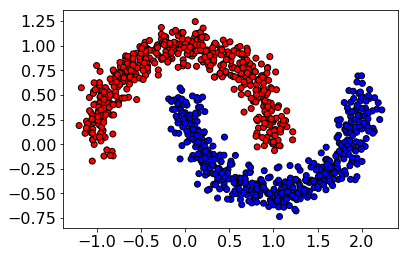

In [73]:
seed = 13
np.random.seed(seed)
no_of_samples = 1000
X, y = make_moons(n_samples=no_of_samples, noise=0.1, random_state=seed)
colormap_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=colormap_bright, edgecolors='k')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

In order to do so, we will built a weighted graph with weights based on the pairwise Euclidean distances between samples. For this, we write a function **pairwise_distances** that takes two arguments *argument1* and *argument2* that are NumPy arrays for which the first dimension equals the number of samples and the second dimension the dimension of each sample. The function should return the pairwise Euclidean distances between the points in the arrays. You can make use of any of the pairwise-distance functions that you have already implemented in MTH786P.

In [74]:
def pairwise_distances(argument1,argument2):
    n=len(argument1)
    distances = np.zeros(shape=(n,n))
    for i in range(n):
        for j in range(i+1,n):
            distances[i,j] = np.sqrt((argument2[j,0]-argument1[i,0])**2+(argument2[j,1]-argument1[i,1])**2)
            distances[j,i] = distances[i,j]
    return distances

Use your function *pairwise_distances* to compute the pairwise distances between *X* and *X* itself and store these distances in an array named *distance_matrix*. 

In [75]:
distance_matrix = pairwise_distances(X,X)

Use these pairwise distances to compute the weights *graph_weights* of your graph via the equation

$$ \text{graph_weights}_{ij} = \begin{cases} \exp(-\gamma \| x_i - x_j \|) & \exp(-\gamma \| x_i - x_j \|) \geq \tau \\ 0 & \text{otherwise} \end{cases} \, , $$

for $i, j \in \{1, \ldots, \text{no_of_samples}\}$. Here $\gamma$ and $\tau$ are positive constants that control the sparsity of the graph. Write a function **create_graph_weights** that takes three arguments *distance_matrix*, *gamma* and *tau* and returns an argument *graph_weights*. Please note that before **create_graph_weights** returns the array *graph_weights*, the array should be converted into a vector with *ndim = 1*.

In [76]:
def create_graph_weights(distance_matrix, gamma, tau):
    n = distance_matrix.shape[0]
    graph_weights = []
    for i in range(n):
        for j in range(n):
            if i!=j:
                if np.exp(-gamma*distance_matrix[i,j])>=tau:
                    graph_weights.append(np.exp(-gamma*distance_matrix[i,j]))
                else:
                    graph_weights.append(0)
    return graph_weights

Create weights *graph_weights* based on your pairwise distances *distance_matrix* for choices $\gamma = 3.5$ and $\tau = 10^{-1}$.

In [77]:
gamma = 3.5
tau = 0.1
graph_weights = create_graph_weights(distance_matrix,gamma,tau)

The following cell tests your code for test specific choices of *gamma* and *tau*.

In [78]:
from numpy.testing import assert_array_almost_equal
test_matrix = X[[70, 320, 785], :]
test_weights = create_graph_weights(pairwise_distances(test_matrix, test_matrix), 1.5, tau)
assert_array_almost_equal(test_weights, [0, 0.18847515, 0, 0.23472212, 0.18847515, 0.23472212])

Next, we use the graph weights to compute the incidence matrix of the graph. For this we modify the function **construct_incidence_matrix** from [Coursework 1](https://qmplus.qmul.ac.uk/pluginfile.php/2816132/mod_resource/content/3/coursework1.pdf) as follows: instead of  the argument *nodes* the modified version takes the argument *no_of_nodes*. Note that the function allows entries of *weights* to be zero, resulting in some rows of the incidence matrix to be zero. All zero matrices should therefore be removed before the incidence matrix is returned. How do you identify the row-indices for which the rows are zero? Use your favourite search engine or the SciPy help.

In [79]:
def construct_incidence_matrix(no_of_nodes, edges, weights):
    no_of_edges = len(edges)
    incidence_matrix = sp.lil_matrix((no_of_edges, no_of_nodes))
    for index in range(no_of_edges):
        indices = edges[index]    
        incidence_matrix[index, indices[0]] = -np.sqrt(weights[index])
        incidence_matrix[index, indices[1]] = np.sqrt(weights[index])
    return incidence_matrix

Define a list *edges* of edges between all nodes that matches the order to the weights *graph_weights* defined earlier.

In [80]:
n = len(X)
edges = []
for i in range(n):
        for j in range(n):
            if i != j :
                edges.append([i,j])

Construct the incidence matrix *incidence_matrix* via **construct_incidence_matrix** for your edges *edges* and weights *graph_weights*. The number of nodes should match the number of samples *no_of_samples*.

In [81]:
incidence_matrix = construct_incidence_matrix(n,edges,graph_weights)

Define the corresponding graph-Laplacian and store it in a variable named *graph_laplacian*.

In [82]:
graph_laplacian = incidence_matrix.T @ incidence_matrix

The graph_laplacian has 208440 non-zero out of 1000000 entries.


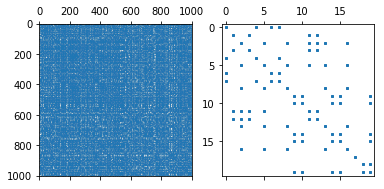

In [83]:
print('The graph_laplacian has {nz} non-zero out of {t} entries.'.format(nz=sp.csr_matrix.count_nonzero( \
        graph_laplacian), t=no_of_samples ** 2))
plt.subplot(1, 2, 1)
plt.spy(graph_laplacian, markersize=0.05)
plt.subplot(1, 2, 2)
plt.spy(graph_laplacian[:20, :20], markersize=2)
plt.tight_layout;

Compute the first two smallest eigenvalues and corresponding eigenvectors and store them in the variables *eigenvalues* and, respectively, *eigenvectors*.

In [84]:
eigenvalues, eigenvectors = sp.linalg.eigs(graph_laplacian, k=2, which='SM')

In [85]:
assert_array_almost_equal(eigenvalues, [0, 3.20827871])
print('The two smallest eigenvalues of the graph-Laplacian are λ0 = {l0:.4f} and λ1 = {l1:.4f}.'.format( \
        l0=eigenvalues[0].real, l1=eigenvalues[1].real))

The two smallest eigenvalues of the graph-Laplacian are λ0 = -0.0000 and λ1 = 3.2083.


Use the second eigenvector to create a Boolean vector *unsupervised_labels* for visualisation of the two moons dataset. What do you observe? How could results be improved?

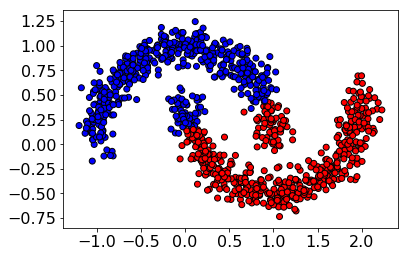

In [86]:
eigvecs = eigenvectors[:, 1].T.real*-1
minimum = min(eigvecs)
vec = eigvecs-minimum

unsupervised_labels =[]
for i in vec:
    if i > 0.06:
        unsupervised_labels.append(1)
    else:
        unsupervised_labels.append(0)
unsupervised_labels

plt.scatter(X[:, 0], X[:, 1], c=unsupervised_labels, cmap=colormap_bright, edgecolors='k')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

We can observe that with paramters gamma=3.5 and tau=0.1, we can not correctly assign labels to the points as there is clearly miss-labelling towards the middle of the image. A solution to this would be to give more weight to the points really close to eachother, which will prevent points near the centre from giving weight across the moons. We can do this by increasing our value for gamma, for example gamma = 10 almost perfectly assigns the labels.

This concludes this week's coursework.